In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import os

In [100]:
test_df = pd.read_csv('./dataset/Test_dataset.csv')
test_df = test_df.drop(columns=['DTS','SGR','ROPA','RMIC','RXO','DCAL','RSHA','DEPTH_MD','Z_LOC','MUDWEIGHT','PEF'])
test_df

,uuid,file_name,BS,ROP,SP,RMED,GR,DTC,Y_LOC,DRHO,RHOB,NPHI,X_LOC,CALI,RDEP,DEPT
0,14812,25_10-10,12.250001,45.224689,NaN,0.992759,61.177399,133.537033,6560993.0,0.010112,2.131319,0.398266,459853.34375,12.301304,1.019758,1348.310400
1,72908,25_10-10,12.250001,49.948738,NaN,0.896075,63.512333,133.525543,6560993.0,0.009631,2.129777,0.389460,459853.34375,12.299226,0.924186,1348.462400
2,103104,25_10-10,12.250001,52.813866,NaN,0.877702,63.515835,130.739624,6560993.0,0.008258,2.138082,0.394868,459853.34375,12.297644,0.895908,1348.614400
3,23480,25_10-10,12.250001,58.635353,NaN,0.928396,63.153057,128.074249,6560993.0,0.015513,2.153999,0.389355,459853.34375,12.276056,0.955895,1348.766400
4,104267,25_10-10,12.250001,58.242565,NaN,0.990412,60.224148,121.454926,6560993.0,0.016630,2.140920,0.365808,459853.34375,12.299644,1.022451,1348.918400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121792,10928,34_3-3 A,8.500000,15.756256,NaN,NaN,65.925987,NaN,NaN,0.043345,2.515146,NaN,NaN,8.647468,NaN,5006.809976
121793,26727,34_3-3 A,8.500000,15.760216,NaN,NaN,66.297127,NaN,NaN,0.053834,2.543073,NaN,NaN,8.636636,NaN,5006.961976
121794,83995,34_3-3 A,8.500000,15.990236,NaN,NaN,64.853714,NaN,NaN,0.055133,2.576337,NaN,NaN,8.592650,NaN,5007.113976
121795,67375,34_3-3 A,8.500000,15.314774,NaN,NaN,62.779541,NaN,NaN,0.047498,2.606787,NaN,NaN,8.546233,NaN,5007.265976


## **CREATE CLUSTER**

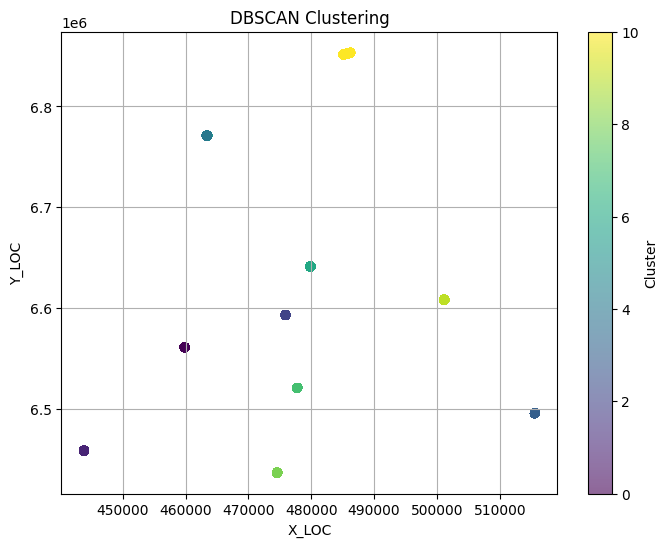

In [101]:
# Get indices of non-null X_LOC and Y_LOC values
valid_indices = test_df[['X_LOC', 'Y_LOC']].dropna().index

# Get X array for clustering
X = test_df.loc[valid_indices, ['X_LOC', 'Y_LOC']].astype(int).values

# Gunakan eps berdasarkan k-dist plot
dbscan = DBSCAN(eps=2, min_samples=5)
clusters = dbscan.fit_predict(X)

# Tambahkan hasil klaster ke test_df
test_df.loc[valid_indices, 'Cluster_DBSCAN'] = clusters

# Plot hasil clustering
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.6)
plt.xlabel('X_LOC')
plt.ylabel('Y_LOC')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

## **SPLIT DATASET BY CLUSTER**

In [102]:
clusters = test_df['Cluster_DBSCAN'].dropna().unique()  # Ambil semua cluster unik

# Buat dictionary untuk menyimpan DataFrame tiap cluster
cluster_dfs = {}

for cluster in clusters:
    cluster_dfs[cluster] = test_df[test_df['Cluster_DBSCAN'] == cluster].copy()

In [104]:
# Buat folder utama untuk menyimpan dataset per cluster
output_folder = './test_dataset/dataset_cluster'
os.makedirs(output_folder, exist_ok=True)

# Iterasi setiap cluster dan simpan sebagai file CSV
for cluster, df in cluster_dfs.items():
    # Tentukan nama file dengan format "(nama_cluster)_dataset.csv"
    filename = f"{cluster}_dataset.csv"
    filepath = os.path.join(output_folder, filename)

    # Simpan DataFrame ke CSV
    df.to_csv(filepath, index=False)

## **LABELLING OUTLIER**

In [105]:
# 1. Pilih fitur untuk analisis (exclude specified columns)
exclude_cols = ['X_LOC', 'Y_LOC', 'DEPT', 'Cluster_DBSCAN','uuid']
numeric_cols = [col for col in test_df.select_dtypes('number').columns if col not in exclude_cols]

# Daftar fitur yang TIDAK BOLEH negatif
cannot_be_negative = ['NPHI', 'RHOB', 'GR', 'PEF', 'CALI', 'BS', 'ROP', 'MUDWEIGHT', 'RDEP', 'RMED', 'DTC', 'DEPT', 'DEPTH_MD']

# Daftar fitur yang BOLEH negatif
can_be_negative = ['SP', 'DRHO', 'Z_LOC', 'X_LOC', 'Y_LOC', 'Cluster_DBSCAN']

# 2. Definisikan fungsi untuk mendeteksi outlier
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Tentukan lower_bound berdasarkan apakah fitur boleh negatif atau tidak
    if column in cannot_be_negative:
        # Untuk fitur yang tidak boleh negatif, lower_bound minimal 0
        lower_bound = max(Q1 - 1.5 * IQR, 0)
    elif column in can_be_negative:
        # Untuk fitur yang boleh negatif, lower_bound = Q1 - 1.5 * IQR
        lower_bound = Q1 - 1.5 * IQR
    else:
        # Default: anggap tidak boleh negatif jika tidak diketahui
        lower_bound = max(Q1 - 1.5 * IQR, 0)
    
    upper_bound = Q3 + 1.5 * IQR
    is_outlier = (df[column] < lower_bound) | (df[column] > upper_bound)
    return is_outlier, lower_bound, upper_bound

# 3. Labeling outlier untuk setiap cluster
for cluster, df_cluster in cluster_dfs.items():
    # Buat DataFrame untuk menyimpan status outlier
    outlier_mask = pd.DataFrame(index=df_cluster.index)
    
    # Deteksi outlier untuk setiap kolom numerik
    for col in numeric_cols:
        if df_cluster[col].notna().any():  # Only process columns with non-null values
            is_outlier, lower_bound, upper_bound = detect_outliers(df_cluster, col)
            outlier_mask[f'{col}_is_outlier'] = is_outlier
         
    # Tambahkan status outlier ke DataFrame cluster
    cluster_dfs[cluster] = df_cluster.join(outlier_mask)
    output_folder = './test_dataset/dataset_cluster'
    filename = f"{cluster}_dataset.csv"
    filepath = os.path.join(output_folder, filename)

    # Simpan DataFrame ke CSV
    cluster_dfs[cluster].to_csv(filepath, index=False)

## **INTERPOLATE OUTLIER**

In [106]:
# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'

# Iterasi setiap subfolder (cluster)
for cluster_file in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_file)
    # Periksa apakah file adalah CSV
    if filename.endswith('.csv'):
        print(f"Reading file: {cluster_path}")
        # Buka file CSV sebagai DataFrame
        df = pd.read_csv(cluster_path)
        
        # Get list of outlier columns
        outlier_cols = [col for col in df.columns if "outlier" in col]
        
        if outlier_cols:  # If there are outlier columns
            # Get corresponding feature columns (remove '_is_outlier' suffix)
            feature_cols = [col.replace('_is_outlier', '') for col in outlier_cols]
                    
            for feature, outlier_col in zip(feature_cols, outlier_cols):
                if outlier_col in df.columns:
                    # Simpan mask NaN asli sebelum mengganti outlier dengan NaN
                    mask_nan_original = df[feature].isna()

                    # Mask untuk outlier
                    mask_outliers = df[outlier_col] == True  

                    # Ganti hanya outlier dengan NaN
                    df.loc[mask_outliers, feature] = None  

                    # Lakukan interpolasi
                    df[feature] = df[feature].interpolate(method='linear')

                    # Kembalikan NaN asli ke posisi semula
                    df.loc[mask_nan_original, feature] = None  
            
            # Save the updated DataFrame
            df.to_csv(cluster_path, index=False)

Reading file: ./test_dataset/dataset_cluster\0.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\1.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\10.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\2.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\3.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\4.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\5.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\6.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\7.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\8.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\9.0_dataset.csv


## **IMPUTE GR WITH INTERPOLATE BY DEPT ORDERING**

In [107]:
# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'

# Iterasi setiap subfolder (cluster)
for cluster_file in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_file)
    # Periksa apakah file adalah CSV
    if filename.endswith('.csv'):
        print(f"Reading file: {cluster_path}")
        # Buka file CSV sebagai DataFrame
        df = pd.read_csv(cluster_path)
        df = df.sort_values(by='DEPT')
        df['GR'].interpolate('linear',inplace=True)
        df.to_csv(cluster_path)

Reading file: ./test_dataset/dataset_cluster\0.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\1.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\10.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\2.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\3.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\4.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\5.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\6.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\7.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\8.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\9.0_dataset.csv


## **CREATE CLUSTER AGAIN IN EACH CLUSTER**

In [108]:
from sklearn.cluster import KMeans
import numpy as np

most_feature_importance = ['GR','DEPT']

# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'

# Iterasi setiap subfolder (cluster)
for cluster_file in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_file)
    # Periksa apakah file adalah CSV
    if cluster_file.endswith('.csv'):
        print(f"Reading file: {cluster_path}")
        # Buka file CSV sebagai DataFrame
        df = pd.read_csv(cluster_path)
        
        X = df[most_feature_importance].dropna()
        
        # Standardize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Range of k values to test
        k_values = range(1, 12)
        inertia_values = []

        # Compute KMeans for each k and store inertia
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia_values.append(kmeans.inertia_)

        # Find the optimal elbow point
        elbow_point = k_values[np.diff(inertia_values, 2).argmin() + 1]
        
        # Fit final KMeans model with optimal number of clusters
        kmeans = KMeans(n_clusters=elbow_point, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        
        # Create a new column for cluster labels
        df['SubCluster'] = np.nan
        df.loc[X.index, 'SubCluster'] = kmeans.labels_
        
        # Save the updated DataFrame
        df.to_csv(cluster_path, index=False)

Reading file: ./test_dataset/dataset_cluster\0.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\1.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\10.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\2.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\3.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\4.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\5.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\6.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\7.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\8.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\9.0_dataset.csv


In [109]:
# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'

# Iterasi setiap file dalam folder utama
for cluster_file in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_file)
    # Periksa apakah file adalah CSV
    if cluster_file.endswith('.csv'):
        print(f"Reading file: {cluster_path}")
        # Buka file CSV sebagai DataFrame
        df = pd.read_csv(cluster_path)

        # Ambil nomor cluster utama dari nama file
        main_cluster = cluster_file.split('_')[0]

        # Jika kolom SubCluster ada dan memiliki nilai
        if 'SubCluster' in df.columns and df['SubCluster'].notna().any():
            subclusters = df['SubCluster'].dropna().unique()

            # Buat folder untuk subcluster
            subcluster_folder = os.path.join(main_folder, f'cluster_{main_cluster}_subclusters')
            os.makedirs(subcluster_folder, exist_ok=True)

            # Simpan setiap subcluster ke file terpisah
            for subcluster in subclusters:
                subcluster_df = df[df['SubCluster'] == subcluster].copy()
                filename = f"cluster_{main_cluster}_subcluster_{int(subcluster)}.csv"
                filepath = os.path.join(subcluster_folder, filename)
                subcluster_df.to_csv(filepath, index=False)

Reading file: ./test_dataset/dataset_cluster\0.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\1.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\10.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\2.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\3.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\4.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\5.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\6.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\7.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\8.0_dataset.csv
Reading file: ./test_dataset/dataset_cluster\9.0_dataset.csv


## **IMPUTE FEATURE IN DATASET SUB CLUSTER**

In [116]:
# Definisi hubungan fitur untuk imputasi
imputation_dict = {
    'NPHI': ['RHOB', 'DTC', 'DEPT'],
    'DTC': ['RHOB', 'NPHI', 'DEPT'],
    'SP': ['GR', 'DEPT','RDEP','RMED'],
    'RHOB': ['NPHI', 'DTC', 'DEPT'],
    'GR': ['DEPT'],
    'CALI': ['DEPT', 'BS'],
    # 'PEF' : ['DRHO','NPHI','DTC'],
    # 'RMED' : ['RHOB','DTC'],
    'DRHO' : ['NPHI', 'DEPT'],
    'ROP' : ['NPHI','DEPT','CALI']
}

def impute_feature(df, target_feature, predictor_features):
    # Periksa apakah kolom target 100% NaN
    if df[target_feature].isna().sum() == len(df):
        print(f"Skipping {target_feature}: 100% NaN.")
        return df  # Kembalikan DataFrame tanpa perubahan
    
    # Periksa apakah semua kolom prediktor 100% NaN
    valid_predictors = [col for col in predictor_features if df[col].isna().sum() < len(df)]
    
    if len(valid_predictors) == 0:
        print(f"Skipping {target_feature}: All predictor columns are 100% NaN.")
        return df  # Kembalikan DataFrame tanpa perubahan

    # Cek apakah ada NaN yang perlu diimputasi di target
    if df[target_feature].isna().sum() > 0:
        print(f"Imputing {target_feature} using {valid_predictors}...")

        # Ambil subset data dengan fitur prediktor valid dan target
        imputation_data = df[valid_predictors + [target_feature]].copy()

        # Standarisasi data
        scaler = StandardScaler()
        imputation_data_scaled = scaler.fit_transform(imputation_data)

        # Terapkan KNN Imputer
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        imputed_data_scaled = imputer.fit_transform(imputation_data_scaled)

        # Kembalikan ke skala asli
        imputed_data = scaler.inverse_transform(imputed_data_scaled)
        imputed_df = pd.DataFrame(imputed_data, columns=valid_predictors + [target_feature], index=df.index)

        # Update DataFrame asli
        df[target_feature] = imputed_df[target_feature]
    else:
        print(f"No NaN values in {target_feature}. Skipping imputation.")
    
    return df

In [117]:
# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'

# Iterasi setiap folder dalam folder utama
for cluster_folder in os.listdir(main_folder):
    cluster_folder_path = os.path.join(main_folder, cluster_folder)
    
    # Periksa apakah ini adalah folder dan mengandung 'subclusters'
    if os.path.isdir(cluster_folder_path) and 'subclusters' in cluster_folder:
        # Iterasi file dalam folder subcluster
        for sub_cluster_file in os.listdir(cluster_folder_path):
            if sub_cluster_file.endswith('.csv'):
                sub_cluster_path = os.path.join(cluster_folder_path, sub_cluster_file)
                print(f"Processing: {sub_cluster_path}")
                try:
                    df = pd.read_csv(sub_cluster_path)
                    # Lakukan imputasi untuk setiap fitur target
                    for target_feature, predictor_features in imputation_dict.items():
                        # Pastikan semua fitur prediktor ada di DataFrame
                        if all(feature in df.columns for feature in predictor_features):
                            df = impute_feature(df, target_feature, predictor_features)
                        else:
                            print(f"Skipping imputation for {target_feature}")
                    df.to_csv(sub_cluster_path, index=False)
                    print(f"Saved to: {sub_cluster_path}")
                except Exception as e:
                    print(f"Error processing {sub_cluster_path}: {str(e)}")

Processing: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_0.csv
Imputing NPHI using ['RHOB', 'DTC', 'DEPT']...
Imputing DTC using ['RHOB', 'NPHI', 'DEPT']...
Skipping SP: 100% NaN.
Imputing RHOB using ['NPHI', 'DTC', 'DEPT']...
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
Imputing DRHO using ['NPHI', 'DEPT']...
No NaN values in ROP. Skipping imputation.
Saved to: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_0.csv
Processing: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_1.csv
No NaN values in NPHI. Skipping imputation.
Imputing DTC using ['RHOB', 'NPHI', 'DEPT']...
Skipping SP: 100% NaN.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
No NaN values in DRHO. Skipping imputation.
No NaN values in ROP. Skipping imputation.
Saved to: ./test_dataset/dataset_cluster\cluster_0

## **MERGE SUB CLUSTER TO CLUSTER**

In [118]:
import os
import pandas as pd

# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'

# Iterasi setiap folder dalam folder utama
for cluster_folder in os.listdir(main_folder):
    cluster_folder_path = os.path.join(main_folder, cluster_folder)
    
    # Periksa apakah ini adalah folder dan mengandung 'subclusters'
    if os.path.isdir(cluster_folder_path) and 'subclusters' in cluster_folder:
        merged_df = pd.DataFrame()
        
        # Iterasi file dalam folder subcluster
        for sub_cluster_file in os.listdir(cluster_folder_path):
            if sub_cluster_file.endswith('.csv'):
                sub_cluster_path = os.path.join(cluster_folder_path, sub_cluster_file)
                print(f"Merging: {sub_cluster_path}")
                try:
                    df = pd.read_csv(sub_cluster_path)
                    merged_df = pd.concat([merged_df, df], ignore_index=True)
                except Exception as e:
                    print(f"Error merging {sub_cluster_path}: {str(e)}")
        
        # Simpan hasil gabungan dalam folder utama dengan nama cluster
        merged_cluster_path = os.path.join(main_folder, f"merged_{cluster_folder}.csv")
        merged_df.to_csv(merged_cluster_path, index=False)
        print(f"Merged cluster saved to: {merged_cluster_path}")

Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_0.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_1.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_2.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_3.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_4.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_5.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_6.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_7.csv
Merging: ./test_dataset/dataset_cluster\cluster_0.0_subclusters\cluster_0.0_subcluster_8.csv
Merged cluster saved to: ./test_dataset/dataset_cluster\merged_cluster_0.0_subclusters.csv
Merging: ./test_dataset/dataset_cluster\cluster_1.0_subclusters\cluster_

## **IMPUTATION IN CLUSTER LEVEL**

In [119]:
import os
import pandas as pd

# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'

# Iterasi hanya file yang sudah digabung (merged)
for merged_file in os.listdir(main_folder):
    if merged_file.startswith('merged_') and merged_file.endswith('.csv'):
        merged_file_path = os.path.join(main_folder, merged_file)
        print(f"Processing merged file: {merged_file_path}")
        try:
            df = pd.read_csv(merged_file_path)
            
            for target_feature, predictor_features in imputation_dict.items():
                # Pastikan semua fitur prediktor ada di DataFrame
                if all(feature in df.columns for feature in predictor_features):
                    df = impute_feature(df, target_feature, predictor_features)
                else:
                    print(f"Skipping imputation for {target_feature}")
            df.to_csv(merged_file_path, index=False)
            print(f"Saved to: {sub_cluster_path}")
        except Exception as e:
            print(f"Error processing {merged_file_path}: {str(e)}")            

Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_0.0_subclusters.csv
No NaN values in NPHI. Skipping imputation.
No NaN values in DTC. Skipping imputation.
Skipping SP: 100% NaN.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
No NaN values in DRHO. Skipping imputation.
No NaN values in ROP. Skipping imputation.
Saved to: ./test_dataset/dataset_cluster\cluster_9.0_subclusters\cluster_9.0_subcluster_8.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_1.0_subclusters.csv
No NaN values in NPHI. Skipping imputation.
No NaN values in DTC. Skipping imputation.
No NaN values in SP. Skipping imputation.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
No NaN values in DRHO. Skipping imputation.
No NaN values in ROP. Skipping imputation.
Saved to: ./test_dataset/dataset_cluster\cluster_9.0_

## **MERGE TO FULL DATASET**

In [120]:
import os
import pandas as pd

# Folder utama tempat dataset tersimpan
main_folder = './test_dataset/dataset_cluster'
output_folder = './test_dataset'

# DataFrame untuk menyimpan semua data
full_merged_df = pd.DataFrame()

# Iterasi hanya file yang sudah digabung (merged)
for merged_file in os.listdir(main_folder):
    if merged_file.startswith('merged_') and merged_file.endswith('.csv'):
        merged_file_path = os.path.join(main_folder, merged_file)
        print(f"Processing merged file: {merged_file_path}")
        try:
            df = pd.read_csv(merged_file_path)
            full_merged_df = pd.concat([full_merged_df, df], ignore_index=True)
        except Exception as e:
            print(f"Error processing {merged_file_path}: {str(e)}")

# Simpan hasil penggabungan ke dalam folder test_dataset
full_merged_path = os.path.join(output_folder, 'full_merged_dataset.csv')
full_merged_df.to_csv(full_merged_path, index=False)
print(f"Full merged dataset saved to: {full_merged_path}")

Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_0.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_1.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_10.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_2.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_3.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_4.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_5.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_6.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_7.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_8.0_subclusters.csv
Processing merged file: ./test_dataset/dataset_cluster\merged_cluster_9.0_subclusters.csv
Full merg

In [ ]:
for target_feature, predictor_features in imputation_dict.items():
    # Pastikan semua fitur prediktor ada di DataFrame
    if all(feature in df.columns for feature in predictor_features):
        df = impute_feature(full_merged_df, target_feature, predictor_features)
    else:
        print(f"Skipping imputation for {target_feature}")

Imputing NPHI using ['RHOB', 'DTC', 'DEPT']...
No NaN values in DTC. Skipping imputation.
Imputing SP using ['GR', 'DEPT', 'RDEP', 'RMED']...
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
No NaN values in DRHO. Skipping imputation.
Imputing ROP using ['NPHI', 'DEPT', 'CALI']...


In [138]:
class FeatureEngineering:
    def __init__(self, df):
        """
        Initialize the FeatureEngineering class with a DataFrame.
        """
        self.df = df.copy()

    def compute_vclay(self):
        """Compute Vclay from Gamma Ray (GR) log."""
        if 'GR' in self.df.columns:
            GR_min, GR_max = self.df['GR'].min(), self.df['GR'].max()
            self.df['Vclay'] = (self.df['GR'] - GR_min) / (GR_max - GR_min)

    def compute_density_porosity(self):
        """Compute Density Porosity (PHI_D) from bulk density (RHOB)."""
        rho_matrix, rho_fluid = 2.65, 1.0  # Assumed matrix and fluid density values
        if 'RHOB' in self.df.columns:
            self.df['PHI_D'] = (rho_matrix - self.df['RHOB']) / (rho_matrix - rho_fluid)

    def compute_sonic_porosity(self):
        """Compute Sonic Porosity (PHI_S) from sonic transit time (DTC)."""
        dt_matrix, dt_fluid = 55.5, 189.0  # Assumed matrix and fluid travel times
        if 'DTC' in self.df.columns:
            self.df['PHI_S'] = (self.df['DTC'] - dt_matrix) / (dt_fluid - dt_matrix)

    def compute_ndpd(self):
        """Compute Neutron-Density Porosity Difference (NDPD)."""
        if 'NPHI' in self.df.columns and 'PHI_D' in self.df.columns:
            self.df['NDPD'] = self.df['NPHI'] - self.df['PHI_D']

    def compute_water_saturation(self):
        """Compute Water Saturation (Sw) using Archie's Equation."""
        if all(col in self.df.columns for col in ['RDEP', 'PHI_D']):
            a, m, n, rw = 1.0, 2.0, 2.0, 0.1  # Archie's parameters
            self.df['Sw'] = (a * rw / self.df['RDEP']) ** (1/n) / self.df['PHI_D'] ** (m/n)

    def apply_feature_engineering(self):
        """Run all feature engineering functions."""
        self.compute_vclay()
        self.compute_density_porosity()
        self.compute_sonic_porosity()
        self.compute_ndpd()
        self.compute_water_saturation()
        print("Feature engineering completed successfully!")
        return self.df

# Initialize FeatureEngineering class and apply feature engineering
feature_engineer = FeatureEngineering(df)
df_engineered = feature_engineer.apply_feature_engineering()

df_engineered = df_engineered[['uuid','SP', 'GR', 'DTC', 'Y_LOC', 'DRHO', 'RHOB', 'NPHI','X_LOC', 'CALI', 'DEPT', 'Vclay', 'NDPD']]
df_engineered.to_csv("./test_dataset/ready_test.csv",index=False)

Feature engineering completed successfully!


In [141]:
df_engineered = df_engineered[['SP', 'GR', 'DTC', 'Y_LOC', 'DRHO', 'RHOB', 'NPHI',
       'X_LOC', 'CALI', 'DEPT', 'Vclay', 'NDPD']]

In [142]:
import joblib
from sklearn.preprocessing import StandardScaler

# Fit the scaler on training data and transform both training and test data
X = scaler.fit_transform(df_engineered)

# Load the model later
loaded_model = joblib.load('extra_trees_model.pkl')

# Use the loaded model for predictions
y_pred_loaded = loaded_model.predict(X)

In [146]:
# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(y_pred_loaded, columns=['prediction'])

# Get the corresponding uuids from df_engineered
predictions_df['uuid'] = test_df['uuid']

# Reorder columns to match required format
predictions_df = predictions_df[['uuid', 'prediction']]

# Map the numerical predictions to lithology names using the mapping
lithology_mapping = {
    30000: "Sandstone",
    65030: "Sandstone/Shale",
    65000: "Shale",
    80000: "Marl",
    74000: "Dolomite",
    70000: "Limestone",
    70032: "Chalk",
    88000: "Halite",
    86000: "Anhydrite",
    99000: "Tuff",
    90000: "Coal",
    93000: "Basement"
}

# Add lithology names
predictions_df['label_name'] = predictions_df['prediction'].map(lithology_mapping)

# Create final submission DataFrame with only uuid and label_name
submission = predictions_df[['uuid', 'label_name']]

In [156]:
submission['label_name'].to_csv("submission_2.0.csv",index=False)

In [151]:
len(list(submission['label_name'].unique()))

11

In [130]:
from pycaret.classification import load_model
from pycaret.classification import *

# Muat kembali model
loaded_model = load_model('best_model_1')

# Gunakan model yang telah dimuat kembali untuk prediksi
test_predictions = predict_model(loaded_model, data=df_engineered)

Transformation Pipeline and Model Successfully Loaded


In [ ]:
import joblib

# Ganti 'label_encoder.pkl' dengan nama file Anda
file_path = "./model/label_encoder.pkl"

# Memuat Label Encoder
label_encoder = joblib.load(file_path)

# Inverse transform the predictions to get original labels
decoded_predictions = label_encoder.inverse_transform(prediction)
print(decoded_predictions)

In [132]:
# Create DataFrame with uuid and predictions
results_df = pd.DataFrame({
    'uuid': test_predictions['uuid'],
    'prediction_label': test_predictions['prediction_label']
})

# Map the numerical predictions to lithology names using the mapping from cell 11
lithology_mapping = {
    30000: "Sandstone",
    65030: "Sandstone/Shale",
    65000: "Shale",
    80000: "Marl",
    74000: "Dolomite",
    70000: "Limestone",
    70032: "Chalk",
    88000: "Halite",
    86000: "Anhydrite",
    99000: "Tuff",
    90000: "Coal",
    93000: "Basement"
}

# Add lithology names
results_df['label_name'] = results_df['prediction_label'].map(lithology_mapping)

# Create final submission DataFrame with only uuid and label_name
submission = results_df[['uuid', 'label_name']]
submission

,uuid,label_name
0,106611,Shale
1,25,Shale
2,97166,Shale
3,3818,Shale
4,101838,Shale
...,...,...
114363,68345,Shale
114364,64174,Shale
114365,43255,Shale
114366,29280,Shale


In [134]:
submission['label_name'].unique()

array(['Shale', 'Sandstone', 'Marl', 'Limestone', 'Tuff',
       'Sandstone/Shale', 'Anhydrite', 'Dolomite', 'Chalk', 'Coal'],
      dtype=object)

In [133]:
len(list(submission['label_name'].unique()))

10

In [ ]:
submission.to_csv("submission.csv",index=False)

In [ ]:
test_predictions

In [ ]:
import pandas as pd

# Data mapping berdasarkan label_code dan label_name
lithology_mapping = {
    30000: "Sandstone",
    65030: "Sandstone/Shale",
    65000: "Shale",
    80000: "Marl",
    74000: "Dolomite",
    70000: "Limestone",
    70032: "Chalk",
    88000: "Halite",
    86000: "Anhydrite",
    99000: "Tuff",
    90000: "Coal",
    93000: "Basement"
}

# Buat kolom baru berdasarkan mapping
test_predictions['label_name'] = test_predictions['prediction_label'].map(lithology_mapping)

test_predictions

,uuid,SP,GR,DTC,Y_LOC,DRHO,RHOB,NPHI,X_LOC,CALI,DEPT,Vclay,NDPD,prediction_label,prediction_score,label_name
0,106611,28.153221,73.680984,136.106262,6560991.5,0.036064,1.992777,0.437895,459855.21875,12.334224,1090.518433,0.425080,0.039578,65000,0.77,Shale
1,25,29.057863,73.533516,136.117981,6560991.5,0.036199,1.992766,0.437893,459855.21875,12.337001,1090.670410,0.424185,0.039569,65000,0.77,Shale
2,97166,37.621056,72.449257,136.129822,6560991.5,0.036340,1.992755,0.437892,459855.18750,12.339778,1090.822388,0.417601,0.039561,65000,0.81,Shale
3,3818,41.995049,71.622238,136.141769,6560991.5,0.036487,1.992744,0.437890,459855.18750,12.342556,1090.974365,0.412580,0.039553,65000,0.80,Shale
4,101838,49.857018,70.987785,136.153839,6560991.5,0.036639,1.992732,0.437888,459855.18750,12.345333,1091.126343,0.408728,0.039544,65000,0.80,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114363,68345,62.094112,100.196724,81.215782,6608171.5,0.018687,2.389765,0.334162,501131.65625,8.522110,3103.160156,0.586074,0.176444,65000,0.87,Shale
114364,64174,61.640255,98.187737,82.007812,6608171.5,0.021687,2.428188,0.326250,501131.65625,8.490946,3103.312256,0.573876,0.191818,65000,0.92,Shale
114365,43255,60.686790,98.161873,80.974220,6608171.5,-0.012134,2.595271,0.305067,501131.59375,8.578125,3116.384277,0.573719,0.271898,65000,0.87,Shale
114366,29280,63.244347,98.657639,83.283325,6608171.5,-0.008411,2.602095,0.282187,501131.59375,8.687500,3117.904297,0.576729,0.253154,65000,0.86,Shale


In [136]:
submission = test_predictions[['uuid','label_name']]

In [137]:
submission['label_name'].unique()

array(['Shale', 'Sandstone', 'Marl', 'Limestone', 'Tuff',
       'Sandstone/Shale', 'Anhydrite', 'Dolomite', 'Chalk', 'Coal'],
      dtype=object)

In [ ]:
submission.to_csv("submission.csv",index=False)